In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from VisPRM_with_LazyPRM import VisPRM_with_LazyPRM
from HierarchicalPRMVisualization import hierarchicalPRMVisualize
from lectures.IPEnvironment import CollisionChecker
from environment import get_all_scenes
import time
import pandas as pd
from scipy.spatial.distance import euclidean

In [4]:
config = {
    "ntry": 50,  # Number of attempts for main planner
    "internal": {
        "initialRoadmapSize": 30,
        "updateRoadmapSize": 10,
        "kNearest": 8,
        "maxIterations": 15
    }
}


🔍 Scene: U-Shape
❌ No path found in scene: U-Shape


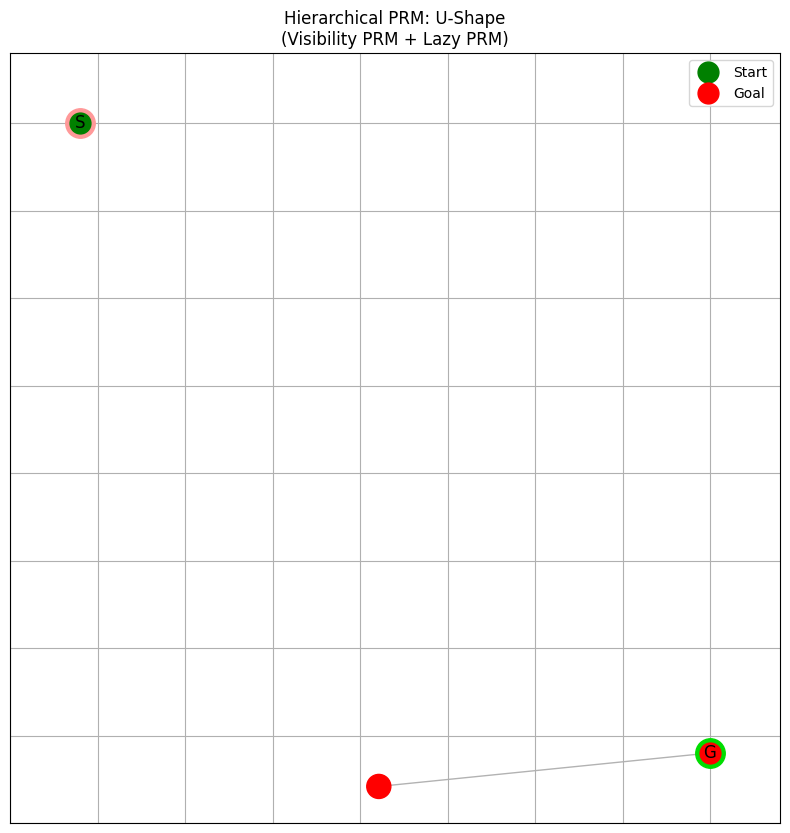


🔍 Scene: L-Shape
✅ Path found in scene: L-Shape, Length: 4


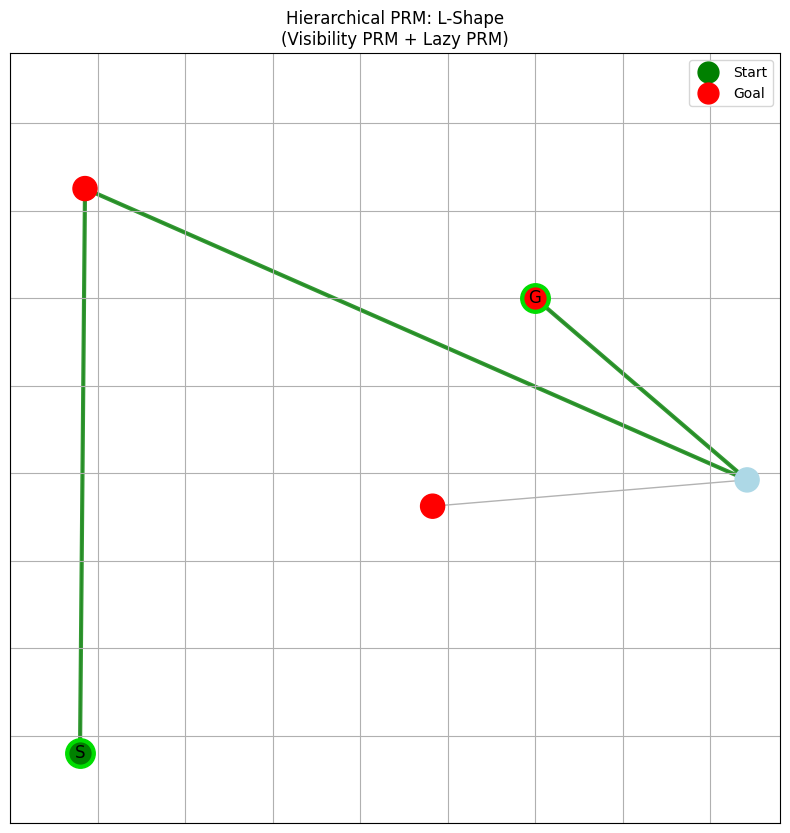


🔍 Scene: Corridor
✅ Path found in scene: Corridor, Length: 4


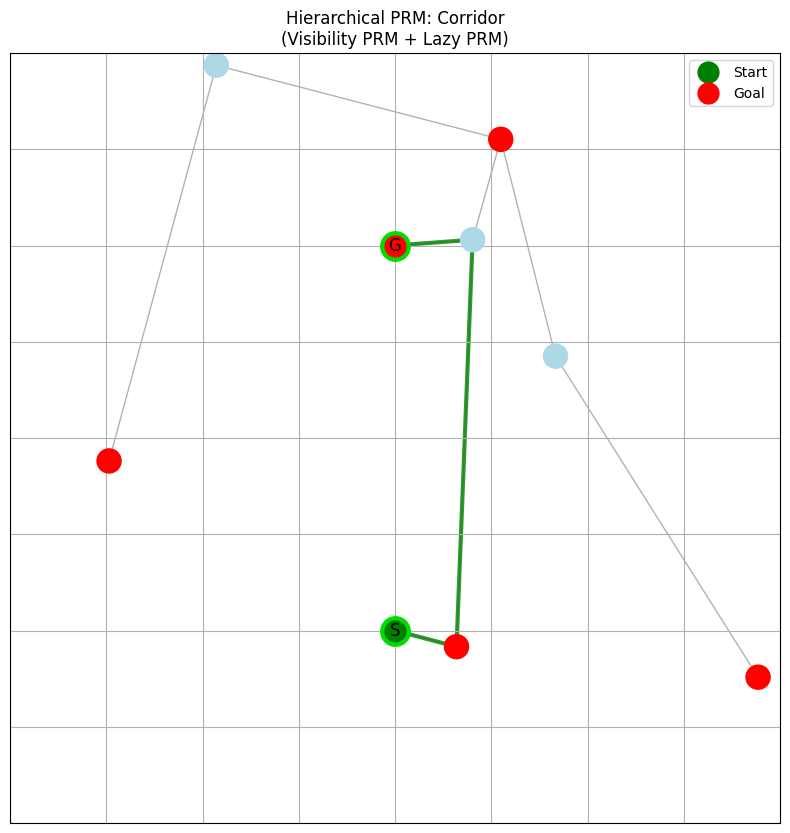


🔍 Scene: Complex Shape


KeyboardInterrupt: 

In [5]:
scenes = get_all_scenes()
results = []

for scene_name, (scene, limits, (start_pos, goal_pos)) in scenes:
    print(f"\n🔍 Scene: {scene_name}")
    start = [list(start_pos)]
    goal = [list(goal_pos)]

    # CollisionChecker instantiation
    collision_checker = CollisionChecker(scene, limits)

    # Hierarchical PRM planner
    planner = VisPRM_with_LazyPRM(collision_checker)

    # Planning with timing
    t0 = time.time()
    result = planner.planPath(start, goal, config)
    t1 = time.time()

    path = result['path'] if result else []
    coords = [planner.graph.nodes[node]['pos'] for node in path] if path else []
    euclidean_length = sum(euclidean(a, b) for a, b in zip(coords[:-1], coords[1:])) if coords else 0

    if not path:
        print(f"❌ No path found in scene: {scene_name}")
    else:
        print(f"✅ Path found in scene: {scene_name}, Length: {len(path)}")

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 10))
    hierarchicalPRMVisualize(planner_result={'roadmap': planner.graph, 'path': path}, ax=ax)
    ax.set_title(f"Hierarchical PRM: {scene_name}\n(Visibility PRM + Lazy PRM)")
    ax.plot(start[0][0], start[0][1], "go", markersize=15, label="Start")
    ax.plot(goal[0][0], goal[0][1], "ro", markersize=15, label="Goal")
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_aspect("equal")
    ax.grid(True)
    ax.legend()
    plt.show()

    # Collect results
    result_data = {
        "scene": scene_name,
        "hasPath": bool(path),
        "length": len(path) if path else 0,
        "euclidean_length": euclidean_length,
        "time": t1 - t0,
        "nodes": len(planner.graph.nodes),
        "edges": len(planner.graph.edges),
        "roadmap_size": planner.graph.size(),
        "internal_checks": result.get('stats', {}).get('visibility_checks', 0),
        "successful_checks": result.get('stats', {}).get('successful_visibility', 0),
        "start_connected": result.get('start_connection', {}).get('success', False),
        "goal_connected": result.get('goal_connection', {}).get('success', False)
    }
    results.append(result_data)

In [4]:
# Results as DataFrame
result_df = pd.DataFrame(results)
print("\n📊 Benchmark Results:")
print(result_df)

# Save results
import os
results_dir = "benchmark_results"
os.makedirs(results_dir, exist_ok=True)
csv_path = os.path.join(results_dir, "HierarchicalPRM_results.csv")
result_df.to_csv(csv_path, index=False)
print(f"💾 Raw data saved to: {csv_path}")


📊 Benchmark Results:
Empty DataFrame
Columns: []
Index: []
💾 Raw data saved to: benchmark_results\HierarchicalPRM_results.csv


In [5]:
# Improved visualization with internal planner metrics
for scene in result_df["scene"].unique():
    df = result_df[result_df["scene"] == scene]
    fig, ax1 = plt.subplots(figsize=(12, 6))
    width = 0.15
    idx = np.arange(1)

    # Main metrics
    ax1.bar(idx, df["length"], width, label="Path Length", color="#1f77b4")
    ax1.set_ylabel("Path Length", color="#1f77b4")
    ax1.tick_params(axis='y', labelcolor="#1f77b4")

    ax2 = ax1.twinx()
    ax2.bar(idx + width, df["euclidean_length"], width, label="Eucl. Length", color="#2ca02c")
    ax2.set_ylabel("Euclidean Length", color="#2ca02c")
    ax2.tick_params(axis='y', labelcolor="#2ca02c")

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('axes', 1.2))
    ax3.bar(idx + 2*width, df["time"], width, label="Time (s)", color="#d62728")
    ax3.set_ylabel("Time [s]", color="#d62728")
    ax3.tick_params(axis='y', labelcolor="#d62728")

    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('axes', 1.4))
    ax4.bar(idx + 3*width, df["roadmap_size"], width, label="Roadmap Size", color="#9467bd")
    ax4.set_ylabel("Roadmap Size", color="#9467bd")
    ax4.tick_params(axis='y', labelcolor="#9467bd")

    ax5 = ax1.twinx()
    ax5.spines['right'].set_position(('axes', 1.6))
    ax5.bar(idx + 4*width, df["internal_checks"], width, label="Visibility Checks", color="#ff7f0e")
    ax5.set_ylabel("Visibility Checks", color="#ff7f0e")
    ax5.tick_params(axis='y', labelcolor="#ff7f0e")

    ax1.set_xticks(idx + 2*width)
    ax1.set_xticklabels([scene])
    ax1.set_title(f"Hierarchical PRM Benchmark: {scene}")

    # Combine legends
    handles, labels = [], []
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    ax1.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.1, 1))

    plt.tight_layout()
    plt.show()

KeyError: 'scene'

In [6]:
# Detailed analysis of internal planner performance
for scene in result_df["scene"].unique():
    df = result_df[result_df["scene"] == scene]
    if df["hasPath"].iloc[0]:
        success_rate = df["successful_checks"].iloc[0] / df["internal_checks"].iloc[0] * 100
    else:
        success_rate = 0

    fig, ax = plt.subplots(figsize=(8, 4))
    metrics = ["Start Connected", "Goal Connected", "Visibility Success Rate"]
    values = [
        df["start_connected"].iloc[0],
        df["goal_connected"].iloc[0],
        success_rate
    ]
    colors = ['#2ca02c', '#2ca02c', '#ff7f0e']

    bars = ax.bar(metrics, values, color=colors)
    ax.set_ylim(0, 100)
    ax.set_ylabel("Success Rate (%)")
    ax.set_title(f"Internal Planner Performance: {scene}")

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%' if isinstance(height, float) else str(height),
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

KeyError: 'scene'